<a href="https://colab.research.google.com/github/tamburins/ESAA_2023/blob/main/ESAA_6_2(182_200p).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04 위성 이미지 분류
## 4-1 텐서플로 데이터셋 로드

인공위성에서 지표면을 촬영한 이미지와 토치이용분류값이 정리되어있는 euroSAT 데이터셋을 제공한다. eu의 코페르니쿠스 지구 관측프로그램에 의해 제공되는 공용 데이터셋인 ㅁㅁ위성이 관측한 이미지를 기반으로 만들어졌다.
텐서플로 데이터셋을 사용하기 위해 라이브러리를 다른 필수라이브러리와 함께 불러온다.

In [1]:
import tensorflow as tf
import numpy as np
import json
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

로드 함수를 이용하여 불러온다. info 변수에 저장되는 메타정보는 옵션이 트루로 설정될땜나 불러올 수 잇다. 이 옵션이 설정되어있지 않으 대는 튜플로 반환된다.

url을 통해 데이터를 다운한다. data dir 옵션에 파일 저장 위치를 지정하면 다운로드한 데이터셋 파일을해당 위치에 저장한다. train 데이터만 제공하기 때문에 80:20 비율로 훈련셋, 검증셋으로 나누어 저장한다.

In [9]:
DATA_DIR = '/content/drive/MyDrive/ESAA/OB'
(train_ds, valid_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:]'],
                                       shuffle_files=True,
                                       as_supervised=True,
                                       with_info=True,
                                       data_dir=DATA_DIR)
print(train_ds, valid_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))> <_PrefetchDataset element_spec=(TensorSpec(shape=(64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


메타정보를 할당받은 info 변수를출력하면 데이터셋에 대한 기본 정보를 보여준다. 앞서 데이터셋의 2가지 유형 중 jpeg 이미지로 인코딩한 rgb datsetㅇ르 다운한 상태이다.

In [3]:
print(info)

tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_path=PosixGPath('/tmp/tmp_e74g5catfds'),
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.47 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=string),
        'image': Image(shape=(64, 64, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('im

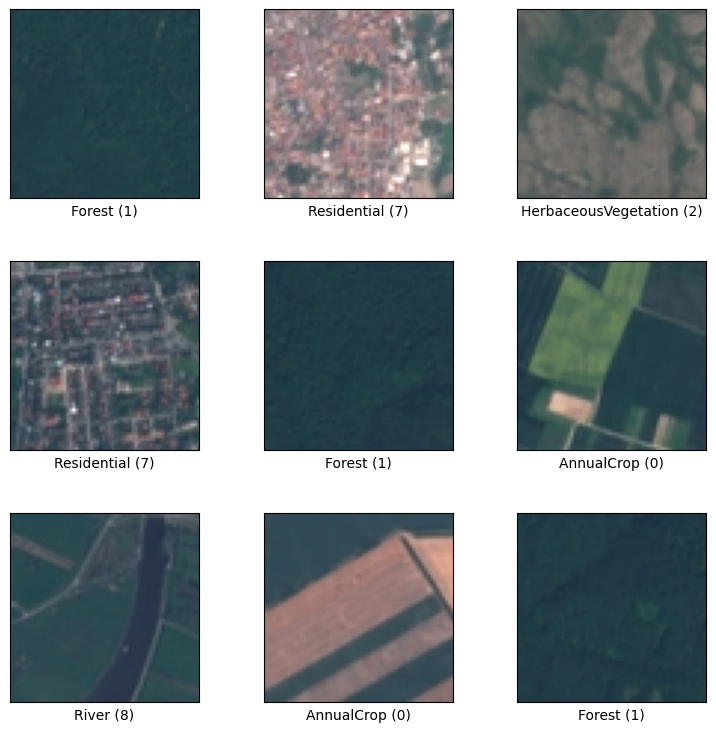

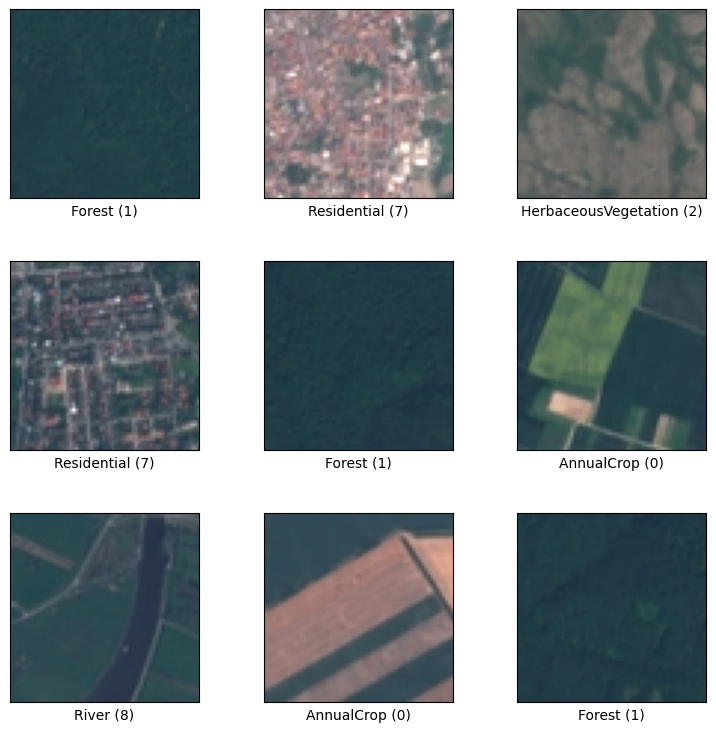

In [14]:
# with show_examples, print( metainfo n image)
tfds.show_examples(train_ds, info)

image  label
0  [[[43, 77, 86], [43, 77, 86], [46, 80, 92], [4...      8
1  [[[101, 104, 111], [105, 108, 117], [112, 116,...      4
2  [[[56, 84, 121], [56, 85, 119], [67, 94, 124],...      5
3  [[[102, 105, 112], [105, 104, 110], [116, 107,...      7
4  [[[82, 98, 97], [83, 97, 97], [86, 97, 99], [9...      0
5  [[[56, 72, 87], [56, 72, 87], [52, 70, 82], [5...      1
6  [[[219, 154, 126], [218, 153, 125], [220, 154,...      0
7  [[[69, 83, 84], [67, 83, 83], [65, 80, 85], [6...      2
8  [[[28, 52, 76], [28, 52, 76], [31, 51, 75], [3...      9
9  [[[45, 75, 77], [46, 74, 78], [49, 69, 78], [6...      8
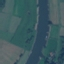
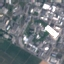
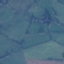
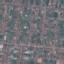
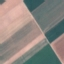
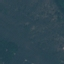
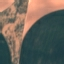
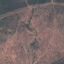
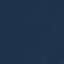
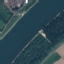

In [15]:
#print sample image 10 with as dataframe
tfds.as_dataframe(valid_ds.take(10), info)

In [16]:
# there are 10 labels
# 0 means annualCrop, 9 means Sea/lake
NUM_CLASSES = info.features['label'].num_classes
print(NUM_CLASSES)

10


클래스를 나타내는 숫자레이블을 메타데이터의 문자열로 변환할 수 있따. 메타데이터의 features 값 중에서 label에 해당하는 메타정보에 int2str 메소드를 적용한다. 클래스 6은 영구작물을 나타내는 것을 확인할 수 있다.

In [17]:
print(info.features['label'].int2str(6))

PermanentCrop


## 4-2 데이터 전처리

텐서플로 데이터ㅔㅅ 사용시 딥러닝 학습에 필요한 데이터셋을 쉽게 구할 수 잇는 장점 외에도 데이터 전처리 과정이 매우 쉽다는 장점을 갖는다.

데이터 전처리에 필요한 함수들을 제공하고 텐서 연산을 효율적으로 처리할 수 있는 최적화를 지원한다.

텐서플로 연산은 float32숫자를 사용하기 때문에 cast 함수를 사용하여 자료형을 float32로 변환한다. 입력이미지는 0-255의 픽셀값을 갖기 때문에 255로 나눠 정규화한다. 이 과정을 preprocess_data 로 정의한다.

map 함수는 사용자저의함수를 매핑하여 텐서플로 데이터셋에 적용하는 메소드로 전처리 과정에서 매우 유용하다. num_parallel_calls 옵션을 오토튠으로 지정하면 텐서플로 병렬연산 처리르 자동으로 최적화한다.

오토튠 적용시 하드웨어 리소스를 병렬로 매핑하여 처리하기 때문에 같은 작업을 훨씬 짧은 시간에 처리할 수 있게 된다.

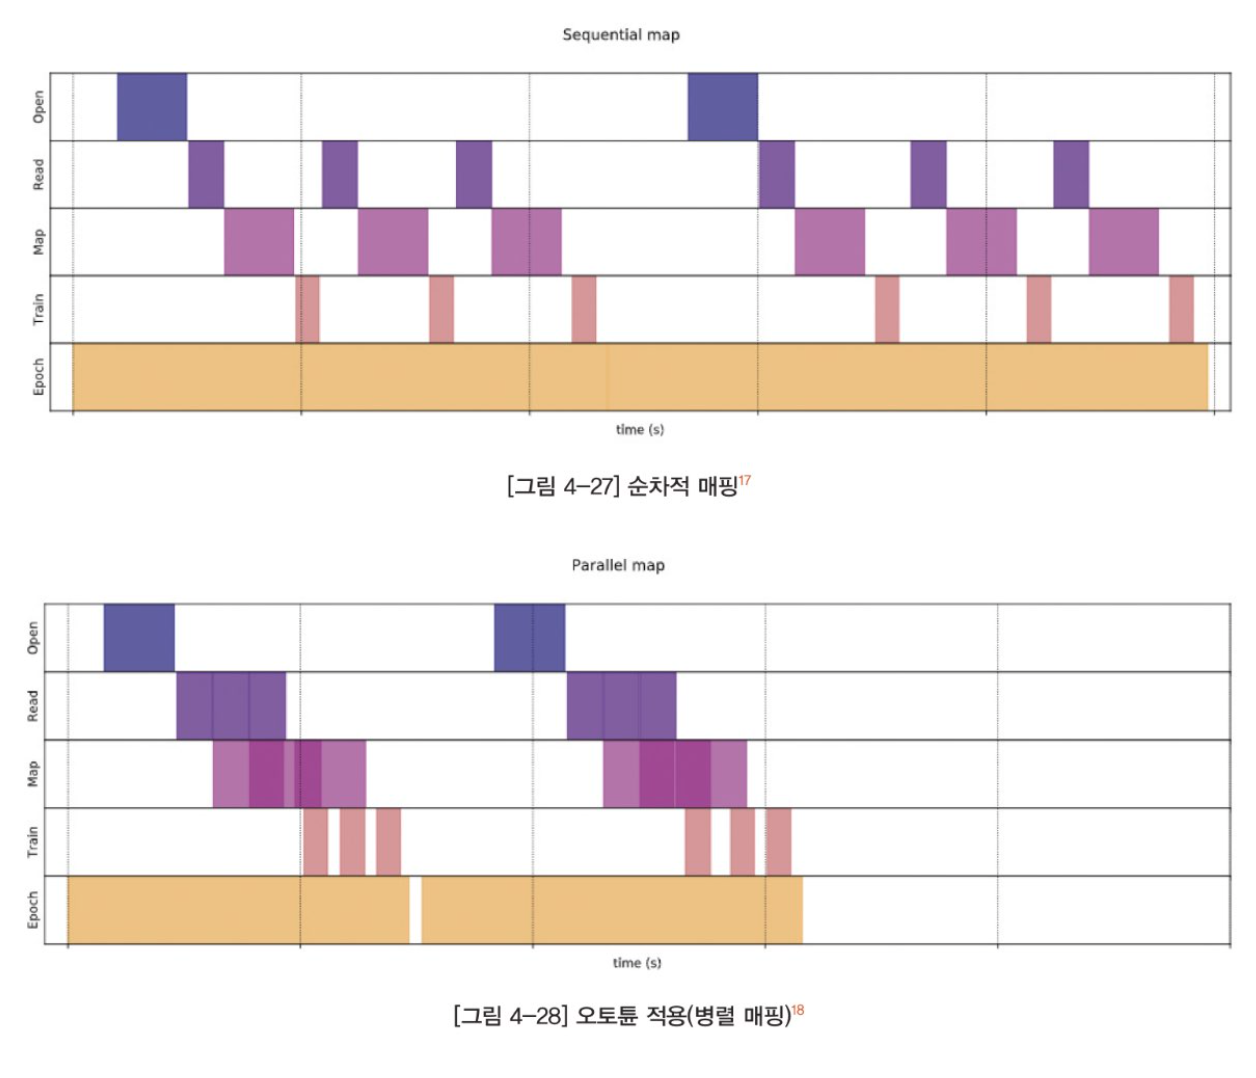

정규화 변환을 마친 데이터셋에 셔플 메소드를 적용하면 순서를 랜덤하게 섞어준다. 모델의 일반화된 성능을 높이기 위해 훈련 데이터셋에서 미니배치를 생성할 때 입력순서에 무작위성을 부여하는 개념이다. 버퍼 사이즈를 1000개로 지정하고 배치사이즈를 64로 지정햇는데 처음 1000개의 데이터를 가져와서 섞고 여기서 64개의 데이터를 랜덤하게 선택하여 하나의 배치를 구성한다.

perfetch 메소드는 모델이훈련을 진행하는 동안 다음에 입력할 데이터를 불러와 미리 전처리를 하도록 조율하는 병렬 처리를 통해 훈련시간을 단축시킨다.

In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
def preprocess_data(image, label):
  image = tf.cast(image, tf.float32)/255.
  return image, label

train_data = train_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
valid_data = valid_ds.map(preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_data = valid_data.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)


## 4-3 모델 훈련 및 검증
배치정규화 합성곱 풀링레이어로 구성된 유닛을 2개 연결하고 덴스 레이어와 드롭아웃으로 구성된 최종 분류기를 갖는 딥러닝 모델을 시퀀셜 api로 생성한다.


In [19]:
def build_model():
  model = tf.keras.Sequential([
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(32,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),
      
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Conv2D(64,(3,3), padding='same', activation='relu'),
      tf.keras.layers.MaxPooling2D((2,2)),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

      ])
  return model
model = build_model()

예측 클래스가 10개인 다중분류 문제에 맞게 손실함수와 평가지표를 설정하고 모델을 50에폭 훈련시킨다.

In [23]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, validation_data=valid_data, epochs=10)

Epoch 1/10
338/338 [==============================] - 222s 654ms/step - loss: 0.0757 - accuracy: 0.9751 - val_loss: 0.8002 - val_accuracy: 0.8427
Epoch 2/10
338/338 [==============================] - 228s 673ms/step - loss: 0.0615 - accuracy: 0.9790 - val_loss: 0.6450 - val_accuracy: 0.8681
Epoch 3/10
338/338 [==============================] - 230s 680ms/step - loss: 0.0544 - accuracy: 0.9825 - val_loss: 0.7093 - val_accuracy: 0.8494
Epoch 4/10
338/338 [==============================] - 219s 649ms/step - loss: 0.0546 - accuracy: 0.9813 - val_loss: 0.6878 - val_accuracy: 0.8568
Epoch 5/10
338/338 [==============================] - 226s 669ms/step - loss: 0.0658 - accuracy: 0.9788 - val_loss: 0.9111 - val_accuracy: 0.8314
Epoch 6/10
338/338 [==============================] - 231s 685ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.9036 - val_accuracy: 0.8462
Epoch 7/10
338/338 [==============================] - 221s 653ms/step - loss: 0.0467 - accuracy: 0.9856 - val_loss: 0.7721 -

모델은 10에폭까지 빠른 속도로 훈련이 진행되면서 손실함수가 급격히 감소하나 그 이후 검증셋에 대한 손실함수가 더이상 줄어들지 앟ㄴ으면서 과대적합 경향을 보인다

In [24]:
def plot_loss_acc(history, epoch):
  loss, val_loss = history.history['loss'], history.history['val_loss']
  acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
  fig, axes = plt.subplots(1,2, figsize=(12,4))

  axes[0].plot(range(1, epoch+1), loss, label='Training')
  axes[0].plot(range(1, epoch+1), val_loss, label='Validation')
  axes[1].legend(loc='best')
  axes[1].set_title('Accuracy')

  plt.show()

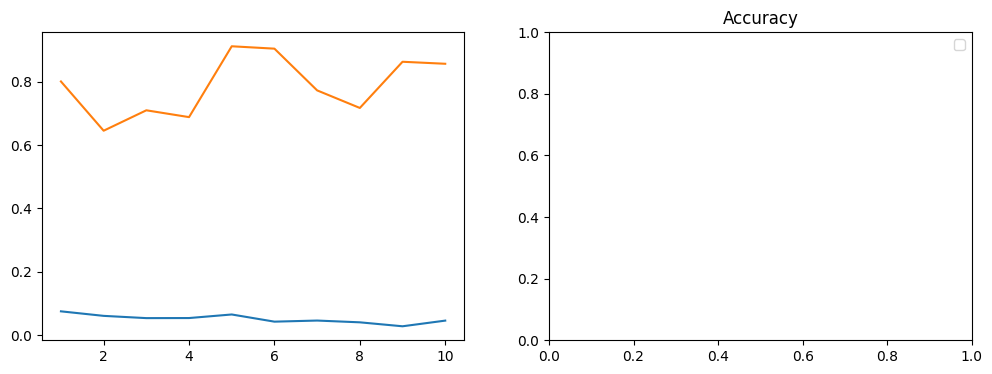

In [26]:
plot_loss_acc(history, 10)

## 4-4 데이터 증강
과대적합 해소 방법으로 배치정규화, 드롭아웃을 적용해도 과대적합이 발생할 경우 이 문제를 해결하고 모델의 일반화된 robust 한 성능을 확보하는 기법으로 사용되는 데이터증강은 이미지 데이터에 여러 변형을 주어 훈련데이터의 다양성을 확보하는 방법이다.

모델이 새 데이터에 대한 예측력을 강화하도록 한다.

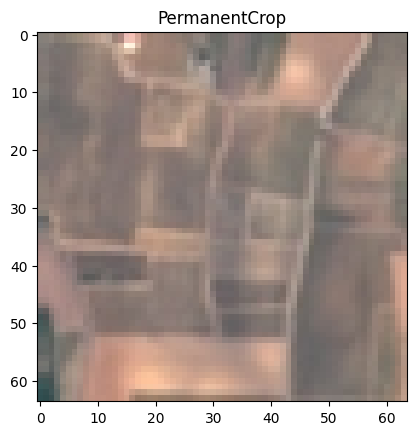

In [29]:
image_batch, label_batch = next(iter(train_data.take(1)))

image=image_batch[0]
label = label_batch[0].numpy()

plt.imshow(image)
plt.title(info.features['label'].int2str(label));

In [30]:
# 샘플이미지에 변화를 주어 전후 이미지를 비교할 수 있는 시각화함수 정의
def plot_augmentation(original, augmented):
  fig, axes = plt.subplots(1,2, figsize=(12,4))
  axes[0].imshow(original)
  axes[0].set_title('Original')

  axes[1].imshow(augmented)
  axes[1].set_title('Augmented')

  plt.show()

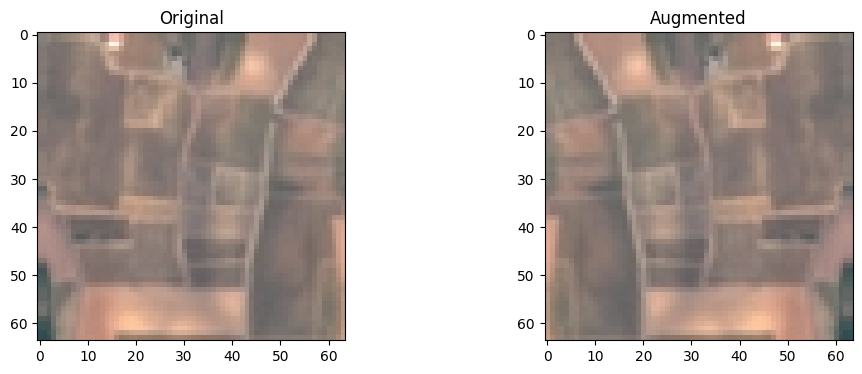

In [31]:
# 좌우반전
lr_flip = tf.image.flip_left_right(image)
plot_augmentation(image, lr_flip)

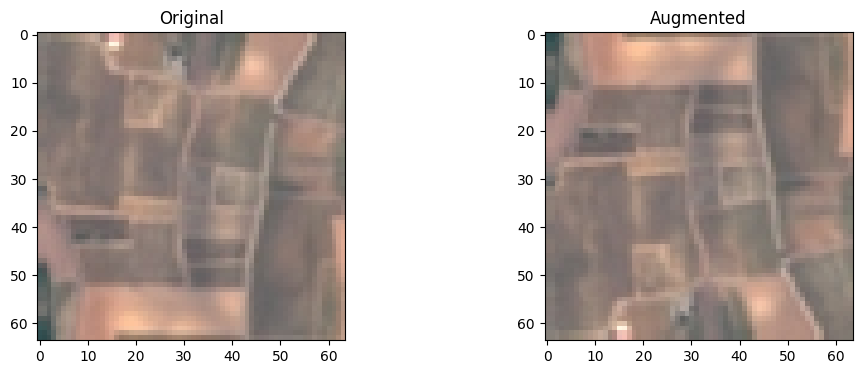

In [33]:
# image 상하뒤집기
ud_flip = tf.image.flip_up_down(image)
plot_augmentation(image, ud_flip)

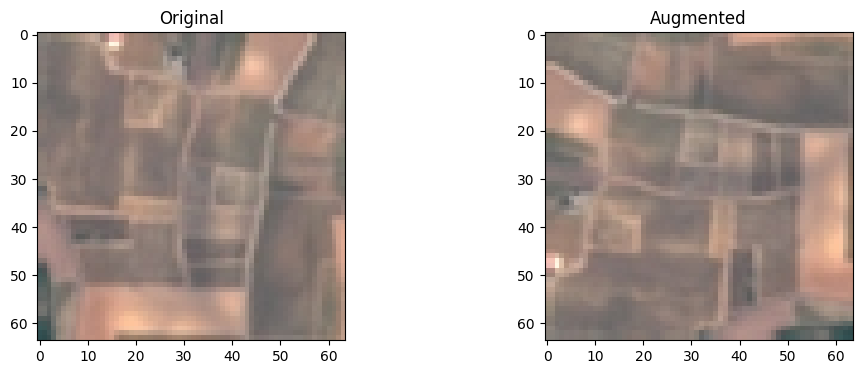

In [34]:
# rot90 함수를 이용하여 이미지를 반시계방향으로 회전시킨다
rotate90 = tf.image.rot90(image)
plot_augmentation(image, rotate90)

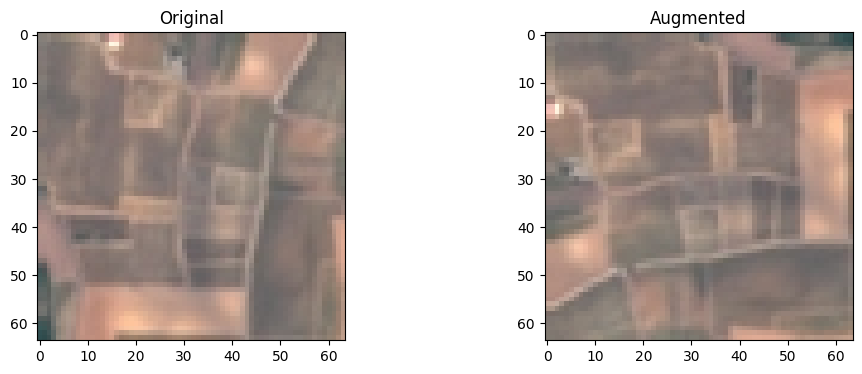

In [35]:
# 행렬의 도치
transpose = tf.image.transpose(image)
plot_augmentation(image, transpose)

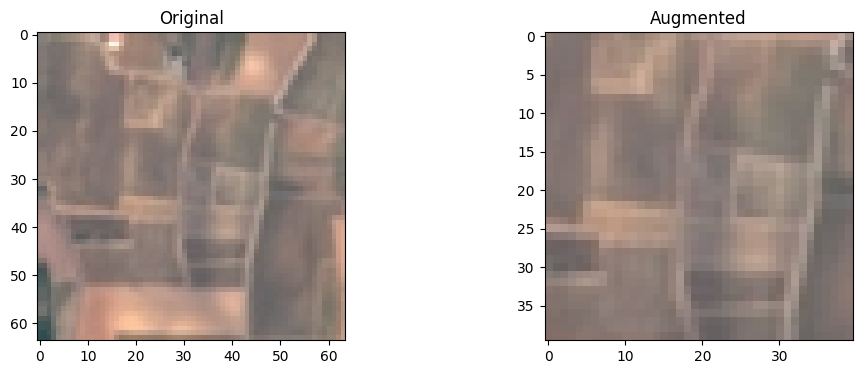

In [38]:
# 이미지 자르기
crop1 = tf.image.central_crop(image, central_fraction=0.6)
plot_augmentation(image, crop1)

resize with crop or pad 함수를 사용하여 원본이미지의 크기를 키우고 랜덤 크롭함수를 사용하고 이미지를 원본 크기와 같게 자르면 원본 이미지가 상하좌우 랜덤방향으로 시프트 이동한다.

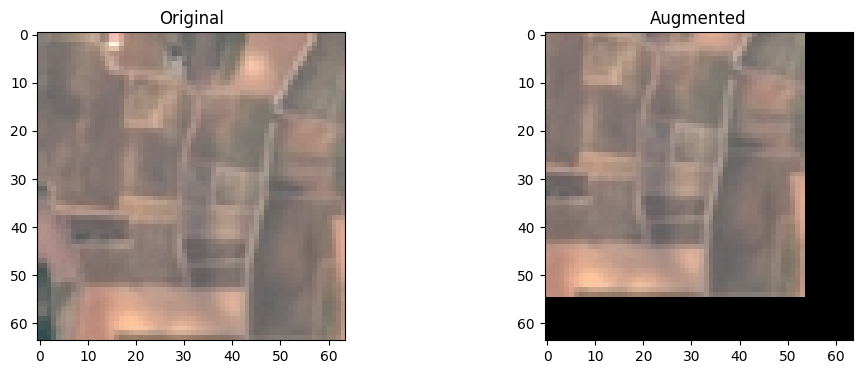

In [39]:
img = tf.image.resize_with_crop_or_pad(image, 64+20, 64+20)
crop2= tf.image.random_crop(img, size=[64,64,3])
plot_augmentation(image, crop2)

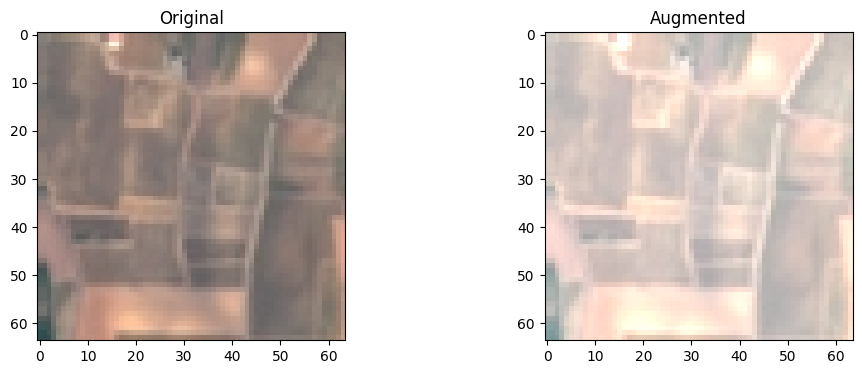

In [40]:
# 이미지 밝기 조절
brightness = tf.image.adjust_brightness(image, delta=0.3)
plot_augmentation(image, brightness)

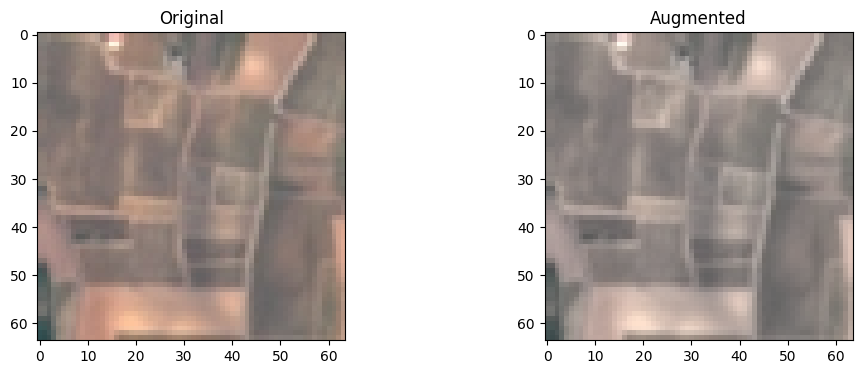

In [41]:
# 이미지채도 조절
saturation = tf.image.adjust_saturation(image, saturation_factor=0.5)
plot_augmentation(image, saturation)

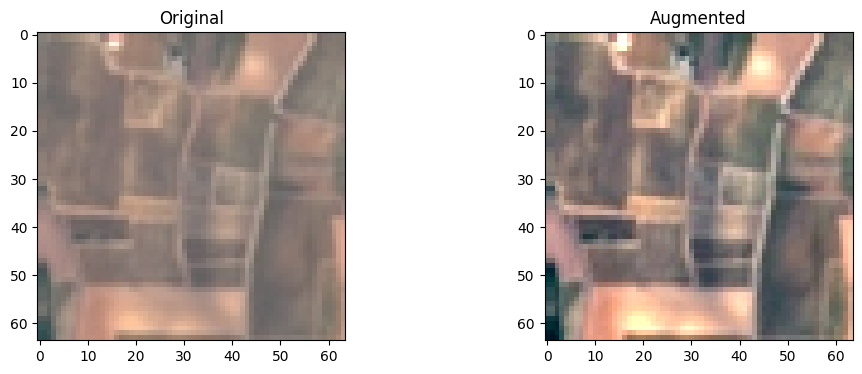

In [42]:
# adjusting contrast
contrast = tf.image.adjust_contrast(image, contrast_factor=2)
plot_augmentation(image, contrast)

다른 여러 기법중 몇가지를 선택하여 데이터 증강 및 전처리를 수행하는 데이터 augmentation 사용자 함수를 정의한다.이미지 증강 효과에 랜덤성을 부여하기 위해 tf.image 모듈에서 지원하는 함수중에서 랜덤으로 시작하는 함수를 적용했다. map 함수로 원본 데이터셋에 적용하고 셔플 함수와 배치 함수등을 적용하여 미니 배치로 만들어준다

In [43]:
def data_augmentation(image, label):
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  image = tf.image.random_brightness(image, max_delta=0.3)
  image = tf.image.random_crop(image, size=[64,64,3])
  
  image = tf.cast(image, tf.float32)/255.

  return image, label

train_aug = train_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
valid_aug = valid_ds.map(data_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_aug=train_aug.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_aug=valid_aug.batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

print(train_aug)
print(valid_aug)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [45]:
# make model instance, train on 50 epochs
aug_model = build_model()

# compile
aug_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# train
aug_history = aug_model.fit(train_aug, validation_data= valid_aug, epochs=10)

Epoch 1/10
338/338 [==============================] - 259s 761ms/step - loss: 1.3548 - accuracy: 0.5142 - val_loss: 1.4194 - val_accuracy: 0.4784
Epoch 2/10
338/338 [==============================] - 229s 678ms/step - loss: 0.9316 - accuracy: 0.6636 - val_loss: 0.9988 - val_accuracy: 0.6468
Epoch 3/10
338/338 [==============================] - 230s 678ms/step - loss: 0.8120 - accuracy: 0.7105 - val_loss: 0.7361 - val_accuracy: 0.7324
Epoch 4/10
338/338 [==============================] - 230s 681ms/step - loss: 0.7186 - accuracy: 0.7436 - val_loss: 0.7419 - val_accuracy: 0.7286
Epoch 5/10
338/338 [==============================] - 235s 693ms/step - loss: 0.6557 - accuracy: 0.7649 - val_loss: 0.5912 - val_accuracy: 0.7901
Epoch 6/10
338/338 [==============================] - 222s 657ms/step - loss: 0.5876 - accuracy: 0.7913 - val_loss: 0.6310 - val_accuracy: 0.7815
Epoch 7/10
338/338 [==============================] - 220s 651ms/step - loss: 0.5565 - accuracy: 0.8005 - val_loss: 0.6184 -

손실함수와 정확도를 그래프로 그려보면 에폭내내 정확도는 우상향하고 손실함수는 감소한다. 즉 과대적합문제가 상당히 개선된 것을 알 수 있다.

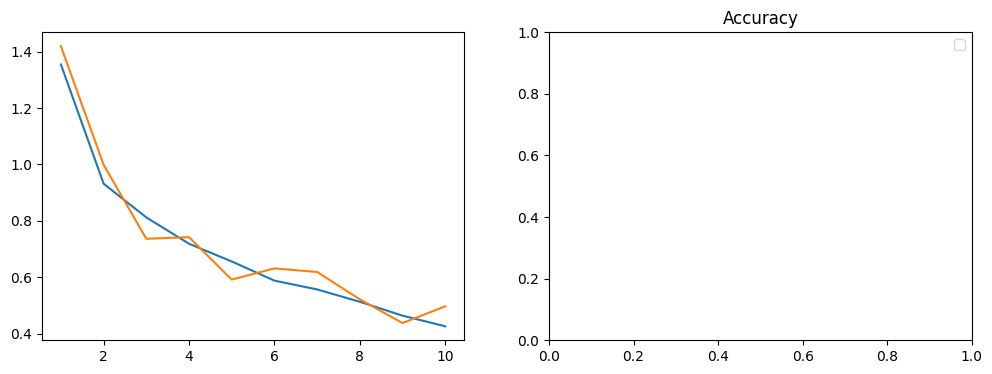

In [47]:
plot_loss_acc(aug_history, 10)


## 4-5 RESNET 사전 학습 모델
이번에는 resnet 을 이용하여 위성이미지를 분류한다. 사전에 방대한 이미지로 훈련받은 딥러닝모델의 구조와 가중치를 그대로 두고 모델 끝단의 탑층에 위성이미지를 분류할 수 있는 최종분류기를 추가하는 바익으로 모델을 구성한다. 이런 식의 구성을 전이학습이라 했다!

케라스에서 모델 인스턴스를 직접 불러올 수 있다. 위성이미지의 크기를 input shape  속성에 저장하고 resnet 모델의 입력크기를 인풋속성에 맞게 줄인다. 분류하려는 클래스 레이블의 개수를 클래스 속성에 지정한다.

가장 중요한 것은 include_top=False로 지정하는 것으로 탑층을 제거하고 해결하려는 문제에 적합한 최종분류기를 대체하여 추가한다.

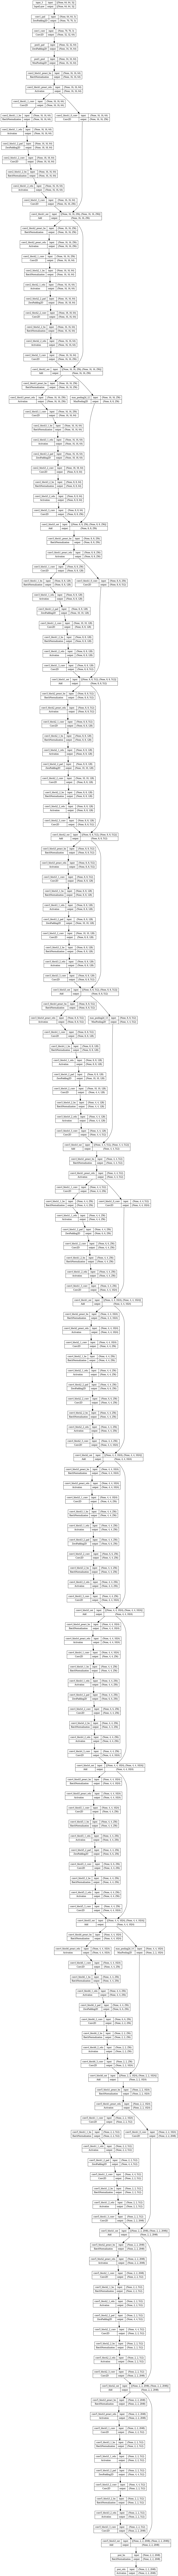

In [53]:
from tensorflow.keras.applications import ResNet50V2

pre_trained_base = ResNet50V2(include_top=False, 
                               weights='imagenet',
                               input_shape=[64, 64, 3])

pre_trained_base.trainable = False

from tensorflow.keras.utils import plot_model
plot_model(pre_trained_base, show_shapes=True, show_layer_names=True, to_file='resnet50.png')
     

num classes 변수가 위성이미지의 클래스 레이블개수인 10을 갖는다. 최종적으로 10개 클래스에 대한 다중분류를 할 수 있도록 덴스레이어의 노드개수와 소프트맥스 활성화 함수를 지정한다.

In [55]:
def build_trainsfer_classifier():
  model = tf.keras.Sequential([
      pre_trained_base,
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dropout(0,3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ])
  return model
tc_model = build_trainsfer_classifier()
tc_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_3 (Flatten)         (None, 8192)              0         
                                                                 
 dense_9 (Dense)             (None, 128)               1048704   
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 10)               